# **CMPE 258 - Assignment 5 Part D**
***Arpitha Gurumurthy***

Full end2end MLOps using xgboost

**Data**: NYC's taxi-fare dataset
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data

**Goal**: Predicting the fare price for a taxi ride in New York City given the pickup and dropoff locations.

XGBoost is an open-source software library which provides a regularizing gradient boosting framework for C++, Java, Python, R, Julia, Perl, and Scala. It works on Linux, Windows, and macOS. From the project description, it aims to provide a "Scalable, Portable and Distributed Gradient Boosting Library".

In [ ]:
# load some default Python modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/My Drive/258_HW5'

In [ ]:
%cd /content/gdrive/My Drive/258_HW5

/content/gdrive/My Drive/258_HW5


In [ ]:
!ls

GCP-Coupons-Instructions.rtf  sample_submission.csv  train.csv
kaggle.json		      test.csv		     train.csv.zip


## **Loading training data**

In [ ]:
taxiFare_df = pd.read_csv('train.csv', nrows=100000)
taxiFare_df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
taxiFare_df.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [ ]:
taxiFare_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,97863.000000,97863.000000,97863.000000,97863.000000,97863.000000,97863.000000
mean,11.343600,-73.975002,40.751225,-73.973929,40.751619,1.674269
std,9.682871,0.039129,0.030231,0.038160,0.033242,1.300176
min,0.000000,-74.438233,40.500046,-74.474595,40.500046,0.000000
25%,6.000000,-73.992258,40.736666,-73.991394,40.735774,1.000000
50%,8.500000,-73.982076,40.753542,-73.980436,40.753972,1.000000
75%,12.500000,-73.968292,40.767687,-73.965127,40.768489,2.000000
max,200.000000,-72.856968,41.692428,-72.854940,41.714633,6.000000


## **Pre-processing**

In [ ]:
##Removing the fare amount that is negative
print("old size: %d" % len(taxiFare_df))
taxiFare_df = taxiFare_df[taxiFare_df.fare_amount >=0]
print("New size: %d" % len(taxiFare_df))

old size: 100000
New size: 99991


In [ ]:
taxiFare_df[taxiFare_df.passenger_count <7][['fare_amount','passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.000000,0.016019
passenger_count,0.016019,1.000000


In [ ]:
##Loading test data
test_df = pd.read_csv('test.csv', nrows=50000)
test_df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [ ]:
test_df.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

No missing values

In [ ]:
# checking for basic stats
test_df.describe()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


Storing the minimum and maximum of the longitude and latitude from test data set and filter the train data set for those data points


In [ ]:
min(test_df.pickup_longitude.min(),test_df.dropoff_longitude.min()), \
max(test_df.pickup_longitude.max(),test_df.dropoff_longitude.max())


(-74.263242, -72.986532)

In [ ]:
min(test_df.pickup_latitude.min(),test_df.dropoff_latitude.min()), \
max(test_df.pickup_latitude.max(),test_df.dropoff_latitude.max())


(40.568973, 41.709555)

In [ ]:
# this function will also be used with the test set below
def select_within_test_boundary(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [ ]:
BB = (-74.5, -72.8, 40.5, 41.8)
print('Old size: %d' % len(taxiFare_df))
taxiFare_df = taxiFare_df[select_within_test_boundary(taxiFare_df, BB)]
print('New size: %d' % len(taxiFare_df))

Old size: 97863
New size: 97863


In [ ]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.slice(0, 16)
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df["weekday"] = df.pickup_datetime.dt.weekday    
    return df

In [ ]:
taxiFare_df = prepare_time_features(taxiFare_df)
test_df = prepare_time_features(test_df)

In [ ]:
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# Returns distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))   # 2*R*asin...

In [ ]:
taxiFare_df['distance_miles'] = distance(taxiFare_df.pickup_latitude, taxiFare_df.pickup_longitude, \
                                      taxiFare_df.dropoff_latitude, taxiFare_df.dropoff_longitude)

In [ ]:
test_df['distance_miles'] = distance(test_df.pickup_latitude, test_df.pickup_longitude, \
                                      test_df.dropoff_latitude, test_df.dropoff_longitude)

Calculating pickup and drop distance for all airports

In [ ]:
def transform(data):
    # Distances to nearby airports, 
    jfk = (-73.7781, 40.6413)
    ewr = (-74.1745, 40.6895)
    lgr = (-73.8740, 40.7769)

    data['pickup_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                         data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_jfk'] = distance(jfk[1], jfk[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_ewr'] = distance(ewr[1], ewr[0], 
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_ewr'] = distance(ewr[1], ewr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    data['pickup_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
    data['dropoff_distance_to_lgr'] = distance(lgr[1], lgr[0],
                                           data['dropoff_latitude'], data['dropoff_longitude'])
    
    return data

taxiFare_df = transform(taxiFare_df)
test_df = transform(test_df)


In [ ]:
##Delete records where distance covered and fare amount are zero, which won't help our model
taxiFare_df[(taxiFare_df['distance_miles']==0)&(taxiFare_df['fare_amount']==0)]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,month,year,weekday,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr


In [ ]:
taxiFare_df[taxiFare_df['fare_amount']==0].shape

(3, 19)

In [ ]:
print("old size: %d" % len(taxiFare_df))
taxiFare_df = taxiFare_df.drop(index= taxiFare_df[taxiFare_df['fare_amount']==0].index, axis=0)
print("New size: %d" % len(taxiFare_df))

old size: 97863
New size: 97860


In [ ]:
##There are 3 record where fare amount is less than 2.5 dollars which doesn't make sense as the base fare for any taxi in new york is 2.5 dollars, we will drop those cases
taxiFare_df[taxiFare_df['fare_amount'] < 2.5].shape

(2, 19)

In [ ]:
print("old size: %d" % len(taxiFare_df))
taxiFare_df = taxiFare_df.drop(index= taxiFare_df[taxiFare_df['fare_amount'] < 2.5].index, axis=0)
print("New size: %d" % len(taxiFare_df))

old size: 97860
New size: 97858


In [ ]:
taxiFare_df[taxiFare_df.passenger_count >= 7]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour_of_day,month,year,weekday,distance_miles,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr


In [ ]:
taxiFare_df.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,97858.0,11.344180,9.682780,2.500000,6.000000,8.500000,12.500000,200.000000
pickup_longitude,97858.0,-73.975002,0.039128,-74.438233,-73.992259,-73.982076,-73.968292,-72.856968
pickup_latitude,97858.0,40.751224,0.030231,40.500046,40.736666,40.753542,40.767685,41.692428
dropoff_longitude,97858.0,-73.973928,0.038159,-74.474595,-73.991394,-73.980435,-73.965128,-72.854940
dropoff_latitude,97858.0,40.751619,0.033241,40.500046,40.735775,40.753972,40.768487,41.714633
passenger_count,97858.0,1.674304,1.300201,0.000000,1.000000,1.000000,2.000000,6.000000
hour_of_day,97858.0,13.494155,6.504697,0.000000,9.000000,14.000000,19.000000,23.000000
month,97858.0,6.262666,3.452179,1.000000,3.000000,6.000000,9.000000,12.000000
year,97858.0,2011.742392,1.868477,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
weekday,97858.0,3.036400,1.949358,0.000000,1.000000,3.000000,5.000000,6.000000


### Lets check the distribution of distance in miles covered for train and test data set


In [ ]:
pd.cut(taxiFare_df['distance_miles'],np.linspace(0, 70, num = 8)).value_counts()

(0.0, 10.0]     94737
(10.0, 20.0]     2015
(20.0, 30.0]       16
(60.0, 70.0]       12
(50.0, 60.0]        7
(40.0, 50.0]        1
(30.0, 40.0]        0
Name: distance_miles, dtype: int64

In [ ]:
# test data set
pd.cut(test_df['distance_miles'],np.linspace(0, 70, num = 8)).value_counts()

(0.0, 10.0]     9611
(10.0, 20.0]     214
(60.0, 70.0]       3
(20.0, 30.0]       1
(50.0, 60.0]       0
(40.0, 50.0]       0
(30.0, 40.0]       0
Name: distance_miles, dtype: int64

In [ ]:
# we will deal with it later 
fare_100 = taxiFare_df[taxiFare_df.fare_amount > 100]
fare_100.shape

(39, 19)

There are 39 records where fare amount is higher than 100 dollars

In [ ]:
fare_100[fare_100.distance_miles <1].shape

(21, 19)

In [ ]:
taxiFare_df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'hour_of_day', 'month', 'year', 'weekday',
       'distance_miles', 'pickup_distance_to_jfk', 'dropoff_distance_to_jfk',
       'pickup_distance_to_ewr', 'dropoff_distance_to_ewr',
       'pickup_distance_to_lgr', 'dropoff_distance_to_lgr'],
      dtype='object')

In [ ]:
# create copy of the data set
df_train = taxiFare_df.drop(columns= ['key','pickup_datetime'], axis= 1).copy()
df_test = test_df.drop(columns= ['key','pickup_datetime'], axis= 1).copy()
print(df_train.shape)
print(df_test.shape)

(97858, 17)
(9914, 16)


## **Splitting training and testing data**

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('fare_amount', axis=1),
                                                    df_train['fare_amount'], test_size=0.2, random_state = 42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(78286, 16)
(19572, 16)
(78286,)
(19572,)


## **XG Boost Model**

In [ ]:
import xgboost as xgb

In [ ]:
params = {
   
    'max_depth': 7,
    'gamma' :0,
    'eta':.03, 
    'subsample': 1,
    'colsample_bytree': 0.9, 
    'objective':'reg:linear',
    'eval_metric':'rmse',
    'silent': 0
}

In [ ]:
def XGBmodel(X_train,X_test,y_train,y_test,params):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params=params,
                    dtrain=matrix_train,num_boost_round=5000, 
                    early_stopping_rounds=10,evals=[(matrix_test,'test')])
    return model

model = XGBmodel(X_train,X_test,y_train,y_test,params)

[05:25:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-rmse:14.2018
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:13.8245
[2]	test-rmse:13.4794
[3]	test-rmse:13.1259
[4]	test-rmse:12.7866
[5]	test-rmse:12.4553
[6]	test-rmse:12.1361
[7]	test-rmse:11.828
[8]	test-rmse:11.5278
[9]	test-rmse:11.2374
[10]	test-rmse:10.9755
[11]	test-rmse:10.7075
[12]	test-rmse:10.4495
[13]	test-rmse:10.1984
[14]	test-rmse:9.95848
[15]	test-rmse:9.72518
[16]	test-rmse:9.50195
[17]	test-rmse:9.28838
[18]	test-rmse:9.0799
[19]	test-rmse:8.88096
[20]	test-rmse:8.68905
[21]	test-rmse:8.50491
[22]	test-rmse:8.3355
[23]	test-rmse:8.16396
[24]	test-rmse:7.99887
[25]	test-rmse:7.8423
[26]	test-rmse:7.69225
[27]	test-rmse:7.54668
[28]	test-rmse:7.40798
[29]	test-rmse:7.2726
[30]	test-rmse:7.14507
[31]	test-rmse:7.02026
[32]	test-rmse:6.9008
[33]	test-rmse:6.78485
[34]	test-rmse:6.6726
[35]	test-rmse:6.5734
[36]	t

In [ ]:
prediction = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit).tolist()

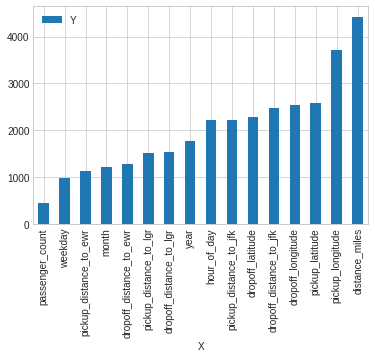

In [ ]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(model.get_fscore().keys()), 'Y': list(model.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

## **Refernces:**
1. https://www.kaggle.com/sandeepkumar121995/eda-data-cleaning-xg-boost
2. https://en.wikipedia.org/wiki/XGBoost